# RAYG GEEs for the HMA study.

The purpose of this notebook is run the generalised estimating equations required to meet the objectives of the HMA study proposed by CB and CMI, as part of the RESHAPE development award. The objectives of the HMA study are to:
1. Describe the distribution of test-status values for patients, stratified by the H.M.A. state of the immediately-prior interval.
2. Describe the distribution of test-status values for patients, stratified by the H.M.A. state sequence of the prior two intervals.

The expected outputs from this notebooks are:
1. Three, four-colour plots showing the average estimated population-averaged probability of each test-status value following each HMA state.
2. Three, four-colour plots showing the average estimated population-averaged probability of each test-status value following each sequence of two preceding HMA states.
3. The exp(coefficient) of the M-state dummy covariate in the GEE with 'Hold' as the reference tells us the population-averaged multiplicative difference in the odds of having an adjacent test-status value, when comparing records that indicated 'Monitor' rather that 'Hold'.*
4. The exp(coefficient) of the A-state dummy covariate in the GEE with 'Hold' as the reference tells us the population-averaged multiplicative difference in the odds of having an adjacent test-status value, when comparing records that indicated 'Adjust' rather than 'Hold'.*
5. The exp(coefficient) of the A-state dummy covariate in the GEE with 'Monitor' as the reference tells us the population-averaged multiplicative difference in the odds of having an adjacent test-status value, when comparing records that indicated 'Adjust' rather than 'Monitor'.*

*I encode an ordinal variable fro the test-status values { Red, Amber, Yellow, Green } as { 1, 2, 3, 4 }.

The outputs 3-5 permit us to make the following statements:
1. \[Output 3\] On average, records indicating a Monitor state had +X / -X times the odds of a worse / better subsequent test-status value, compared to records indicating a Hold state.
2. \[Output 4\] On average, records indicating a Adjust state had +X / -X times the odds of a worse / better subsequent test-status value, compared to records indicating a Hold state.
3. \[Output 5\] On average, records indicating a Adjust state had +X / -X times the odds of a worse / better subsequent test-status value, compared to records indicating a Monitor state.


### A note on interpretation.
Odds ratios are used to quantify association but they do not quantify causality without the data and modelling satisfying strict assumptions. It is not possible in this observational study to satisfy such assumption, though we do make efforts toward that ideal. Thus, for example, should a previous 'Hold' H.M.A. state be associated with better test-status values, we cannot conclude that enforcing a 'Hold' state (i.e. not monitoring for 6 months and not changing any prescriptions) with result in better test-status values.

Install R packages.

In [852]:
script_start_time <- Sys.time()
#######################
## Install packages. ##
#######################
if( !"pacman" %in% installed.packages() ){ install.packages( "pacman" ) }
pacman::p_load(
    bigrquery
    ,ggplot2
    ,tidyverse
)

if( !"V8" %in% installed.packages() )
    {
    Sys.setenv(DOWNLOAD_STATIC_LIBV8 = 1)
    install.packages("V8")
    remotes::install_github("jtextor/dagitty/r")
    library(dagitty)
    require('IRdisplay', quietly = TRUE)
}

## Generate the cohort.

In [853]:
source('RESHAPE_cohort_generator.r')

Auto-refreshing stale OAuth token.



## Format the data.

In [854]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


Prepare a dataset for the Generalised Estimating Equation. Keep in mind that the `test_status` variable is ordered 1 to 4 from Red to Green, and the HMA variable is ordered 1 to 3 from Hold to Adjust.

In [855]:
gee_dataset <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::distinct( person_id, event_value, HMA) %>%
    dplyr::filter( stringr::str_detect( event_value, pattern = "Test" ) ) %>%
    dplyr::mutate( event_value = event_value %>% droplevels() %>% ordered() ) %>%
    dplyr::mutate( HMA = HMA %>% droplevels() ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, rn ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::rename(
        test_status = event_value
        ,previous_HMA_state = HMA
    ) %>%
    dplyr::mutate( previous_test_status = lag( test_status ) ) %>%
    dplyr::ungroup() 

## Specifying the parameters for the estimating equation.
There are several parameters that must be specified to fit the Generalised Estimating Equation, four of which I will specify explicitly:
1. local odds ratio structure
2. link function
3. covariates
4. form of covariate

### 1. Choosing the local odds ratio structure.
The local odds ratio structure is the equivalent of the covariance structure in a standard GEE. That is to say, the local odds ratio structure sets up what I assume to be the dependency / association between the repeated observations. Repeated observations are grouped into 'blocks' - in our case, based on `person_id` - and then we have to decide:
1. how we assume the repeated observations of the variate (i.e. `test_status`) relate to each other; and
2. how the levels of the variate (i.e. {Red, Amber, Yellow, Green}) at each observation timepoint relate to each other.

Following Occam's razor, it's best to choose the simplist local odds ratio stucture that still represents the dependencies / associations between the difference levels of the variate at the repeated observation timepoints. The authors of the `multgee::ordLORgee()` function that I am using suggest that one should start by checking the range of the intrinsic parameters for the dataset. If the range is less than two, then I am probbably safe to set the local odd ratio structure to `"uniform"`, which would assume that the dependency / assocation between levels of the variate are all the same at all observation timepoints. (Note: An intrinsic parameter is a unitless measure of association inherent to the construction of local odds ratios. There is an intrinsic parameter for every adjacent 2-by-2 table that compares levels of the variate at between successive observation timepoints).

The range of the intrinsic parameters in our dataset is shown below.

In [856]:
ips <-
multgee::intrinsic.pars(
                        y = gee_dataset$test_status
                         ,data = gee_dataset
                         ,id = person_id
                         ,repeated = rn
                         ,rscale = "ordinal"
                         )
print(
    paste0(
        "The range of the intrinic paramters is "
        ,max( ips ) - min( ips )
        )
    )

Warning message:
“glm.fit: fitted rates numerically 0 occurred”


[1] "The range of the intrinic paramters is 10.8793206483064"


The range of the intrinsic parameters is greater than 2, so it is probably not appropriate to fit the local odds ratios structure as `"uniform"`. 

I fit the GEE using all structures that are available in the `multgee::ordLORgee()` function, and found that the local odds ratios all land around 1.00. The GEE coefficients also don't differ to any meaningful degree depending on the local odds ratio structure that is assumed. Therefore, I conclude that the choice of local odds ratio structure is not important in my case (In fact, the premise of the local-odds-ratio approach to GEEs is that the local odds ratios are nuisance parameters, so I shouldn't expect much insight from them, anyway).

Ultimately, I choose the `"time.exch"` local odds ratio structure because I think it is appropriate to assume the associations between levels of the variate are consistent over repeated observations, but that those associations are permitted to different for each pair of levels being compared. For example, the association between whether a patient's record indicated `Test Status = Green` or `Test Status = Yellow` at timepoints t1 and t2 is the same as the association at timepoints t2 and t3, but the value of the association can be different for the comparison between `Test Status = Amber` and `Test Status = Red`. My justification comes from the consistency in the proportion of transitions between test-status values, as seen in the Sankey plots from the ClearPath studies. To be clear, the `"time.exch"` structure assumes that there is a dependency / assocation between successive observations, and that the dependency / association is the same for every pair of antecedent and subsequent (similar to a Markov model).

I would have preferred to have set the `"independence"` local odds ratio structure, which would have permitted the odds ratios to vary between both variate level comparisons and timepoints, but the local odds ratios that are returned by the `multgee::ordLORgee()` function are all the same and all equal '1' exactly with no decimal places, suggesting improper estimation. This seems pathological and might be a sign of the convergence problems identified by the authors with the `"independence"` local odds ratio structure (see the second-to-last paragraph of section 6 in [Touloumis (2015)](https://www.jstatsoft.org/article/view/v064i08)). The `"time.exch"` local odds ratio structure provides plausible estimates that do not differ much from the '1' value provided by the `"independence"` local odds ratio structure.

(For future versions of this study, I might define my own, bespoke local odds ratio structure.)

### 2. Choosing the link function.
The most-common choice of link function for ordinal multinomial regression models is the cumulative logit link. For my case of a variate with four levels, the cumulative logit link function would compute the population averages for:

$$log\left(\frac{P(test\_status = Red)}{P(test\_status = \{Amber\ or\ Yellow\ or\ Green\})}\right)$$

$$log\left(\frac{P(test\_status = \{Red\ or\ Amber\})}{P(test\_status = \{Yellow\ or\ Green\})}\right)$$

$$log\left(\frac{P(test\_status = \{Red\ or\ Amber\ or\ Yellow\})}{P(test\_status = Green)}\right)$$

Note that the comparison (i.e. what is above and below the line) is between every variate level either side of a different threshold.

In contrast, the adjacent category logit compares each variate level with its adjacent level, only:

$$log\left(\frac{P(test\_status = Red)}{P(test\_status = Amber)}\right)$$

$$log\left(\frac{P(test\_status = Amber)}{P(test\_status = Yellow)}\right)$$

$$log\left(\frac{P(test\_status = Yellow)}{P(test\_status = Green)}\right)$$

I choose the adjacent category logit because I am interested in the population averages for the specific comparisons of variate levels.

### 3. Choosing the covariates.
It is crucial for unbiased inference that confounding bias is mitigated and collider bias is not induced. I use a directed acyclic graph to present my hypothesised map of how the variables associated with my research question relate to each other. From this graph, I can identify what covariates are required to mitigate confounding bias and mitigate contamination from unintentional collider bias.

The R syntax below defines the directed acyclic graph and then outputs the list of covariates that are needed to mitigate bias in the modelling of the association between test status and the previous HMA state.

In [857]:
GEE_dag <- dagitty::dagitty('
dag {
bb="0,0,1,1"
D_tminus3 [latent,pos="0.097,0.331"]
D_tminus2 [latent,pos="0.290,0.346"]
D_tminus1 [latent,pos="0.507,0.348"]
D [latent,pos="0.729,0.342"]
HMA_tminus2 [pos="0.377,0.892"]
HMA_tminus1 [exposure,pos="0.618,0.894"]
HMA [pos="0.834,0.890"]
Rx_tminus3 [pos="0.178,0.499"]
Rx_tminus2 [pos="0.375,0.507"]
Rx_tminus1 [pos="0.614,0.499"]
Rx [pos="0.836,0.516"]
test_status_tminus3 [pos="0.101,0.132"]
test_status_tminus2 [pos="0.290,0.121"]
test_status_tminus1 [adjusted,pos="0.512,0.113"]
test_status [outcome,pos="0.728,0.113"]
dT_tminus3 [pos="0.174,0.692"]
dT_tminus2 [pos="0.378,0.694"]
dT_tminus1 [pos="0.609,0.701"]
dT [pos="0.837,0.711"]
D_tminus3 -> D_tminus2
D_tminus3 -> Rx_tminus3
D_tminus3 -> dT_tminus3
D_tminus2 -> D_tminus1
D_tminus2 -> Rx_tminus2
D_tminus2 -> dT_tminus2
D_tminus1 -> D
D_tminus1 -> Rx_tminus1
D_tminus1 -> dT_tminus1
D -> Rx
D -> dT
Rx_tminus3 -> D_tminus2
Rx_tminus3 -> HMA_tminus2
Rx_tminus2 -> D_tminus1
Rx_tminus2 -> HMA_tminus2
Rx_tminus2 -> HMA_tminus1
Rx_tminus1 -> D
Rx_tminus1 -> HMA_tminus1
Rx_tminus1 -> HMA
Rx -> HMA
test_status_tminus3 -> D_tminus3
test_status_tminus3 -> test_status_tminus2
test_status_tminus2 -> D_tminus2
test_status_tminus2 -> test_status_tminus1
test_status_tminus1 -> D_tminus1
test_status_tminus1 -> test_status
test_status -> test_status
dT_tminus3 -> HMA_tminus2
dT_tminus2 -> HMA_tminus1
dT_tminus1 -> HMA
}
')
print( dagitty::adjustmentSets( GEE_dag, exposure = "HMA", outcome = "test_status", effect = "total" ) )

{ test_status_tminus1 }


The results show that I only need to include the immediately-preceding test_status as a covariate, in addition to my exposure covariate.

But, the covariate assessment is only valid if the hypothesised graph is valid. The following R syntax details the testable statistical implications of my graph, which would need to be true if my graph were valid.

In [858]:
testable_implications <- dagitty::impliedConditionalIndependencies( GEE_dag )
print( paste0( "There are ", testable_implications %>% length(), " testable implications." ) )

[1] "There are 64 testable implications."


In [859]:
###### TEST THE TESTABLE IMPLICATIONS

### 4. Form of covariates.
Now that I have identified my covariates, I need to choose how best to represent that covariate in the GEE.

Both covariates `previous_HMA_status` and `previous_test_status` are ordinal factors. I could represent them as numeric covariates, which would provide a single coefficient for me to interpret the population-averaged log-odds test-status values. The caveat is that this coefficient represents the population-averaged log-odds corresponding to a 1-unit difference in the covariate, on average, so:
1. I can't if there are differences between any particular pairing of the covariate levels (e.g. Hold-vs-Monitor compare to Monitor-vs-Adjust),
2. I can't know about greater-than-1-unit changes (e.g. Hold-vs-Adjust, which skips the Monitor level), and
3. technically, the coefficient applies to nonsensical values of the covariate beyond the numeric range that don't exist (e.g. Hold = 1 but the coefficient is averaged of values up to infinity for which there is no HMA state).

The alternative is to represent the covariates with dummy encoding. The benefit is that each coefficient can be interpreted as the population-averaged log-odds of the test-status value comparing specific pairs of levels of the covariate. Specifically, each dummy variable encodes the log-odds for comparison to a reference value. The disadvantage of this representation is that I will have to run multple estimations with different the reference values to estimate the population-averaged log-odds for all possible pairs of levels of the covariate.

Based on these considerations:
1. I will use the dummy encoding for the exposure covariate, so that I can estimate pair-specific specific population-averaged log-odds.
2. I will use the dummy encoding for the confounding-adjustment covariate, because this is the lagged-by-1 variate value that is already being represented non-numerically.

## Run the estimations.
I want to estimate the following population-averaged log-odds for the `previous_HMA_state` covariate:
1. Hold-vs-Monitor (Hold as reference)
2. Hold-vs-Adjust (Hold as reference)
3. Monitor-vs-Adjust (Monitor as Monitor)

Odds are symmetrical, so estimating these three log-odds means I immediately know the opposite odds. For example, if the odds ratio for Hold-vs-Monitor (Hold as reference is 1.2, then this means that the Monitor state is 1.2-times the odds of the Hold state AND that the Hold state is approximately 0.8-times the odds of the Monitor state.

To estimate these coefficients, I need to run the same GEE specification but:
1. `GEE_holdAsReferenceLevel` will have Hold as the reference level in `previous_HMA_state`, and 
2. `GEE_monitorAsReferenceLevel` will have Monitor as the reference level in `previous_HMA_state`.

In [860]:
GEE_holdAsReferenceLevel <-
multgee::ordLORgee(
        formula = test_status ~ previous_HMA_state + previous_test_status
        #,link = "acl"
        ,id = person_id
        ,repeated = rn
        ,data = gee_dataset %>% 
                    dplyr::mutate(
                        previous_HMA_state = relevel( as.factor( previous_HMA_state ), ref = 1 )
                    )
        ,LORstr = "time.exch"
    )


GEE_monitorAsReferenceLevel <-
multgee::ordLORgee(
        formula = test_status ~ previous_HMA_state + previous_test_status
        #,link = "acl"
        ,id = person_id
        ,repeated = rn
        ,data = gee_dataset %>% 
                    dplyr::mutate(
                        previous_HMA_state = relevel( as.factor( previous_HMA_state ), ref = 2 )
                    )
        ,LORstr = "time.exch"
    )

## Check the generalisability of the GEEs.
We need to check two p-values to understand whether our estimates are generalisable to our study population or limited to our sample.

The first is the p-value for the GEE, overall. If the p-value of the GEE is not statistically significant, then we infer that the spread of the observed data is such that none of our estimated differences in odds would are likely be found in the study population beyond our sample (even though it is the observed difference in odds within our sample). More data would need collecting or the model would need respecifying.

If the p-value of the GEE is statistically significant, then we proceed to review the estimated coefficients.

The second p-value(s)  is for the estimate of the previous HMA state.  The covariate `previous_HMA_state` is dummy coded so it has two coefficients, and thus, we have to review two p-values. If the coefficients are statistically significant, then we infer that it is likely that a difference in odds at least as large as we estimated would be found in the study population beyond our sample.

If coefficient is not statistically significant, then we infer that the spread of the observed data is such that the estimated odds ratios are statistically similar to equality, i.e. it is unlikely that a difference in odds at least as large as we estimated would be found in the study population beyond our sample (even though it is the observed difference in odds within our sample).

If we have found that both the GEE and a particular coefficient are statistically significant, then our concluding statements can be presented as inferences about the study population; if not, then our concluding statements must be presented as descriptions about the study sample.

The p-values are presented below.

In [861]:
print("GEE_holdAsReferenceLevel")
pval_extraction <- summary( GEE_holdAsReferenceLevel ) %>% `[`( c("pvalue", "coefficients"))
pval_model <- pval_extraction$pvalue %>% as.numeric()
pval_coeffs <- pval_extraction$coefficients[ c('previous_HMA_stateMonitor', 'previous_HMA_stateAdjust'), 'Pr(>|san.z|)']
pvals <- c(pval_model, pval_coeffs)
ifelse( pvals < 0.0001, "< 0.0001", pvals)

print("GEE_monitorAsReferenceLevel")
pval_extraction <- summary( GEE_monitorAsReferenceLevel ) %>% `[`( c("pvalue", "coefficients"))
pval_model <- pval_extraction$pvalue %>% as.numeric()
pval_coeffs <- pval_extraction$coefficients[ c('previous_HMA_stateHold', 'previous_HMA_stateAdjust'), 'Pr(>|san.z|)']
pvals <- c(pval_model, pval_coeffs)
ifelse( pvals < 0.0001, "< 0.0001", pvals)

[1] "GEE_holdAsReferenceLevel"


previous_HMA_stateMonitor  previous_HMA_stateAdjust 
               "< 0.0001"                "< 0.0001"                "< 0.0001"

[1] "GEE_monitorAsReferenceLevel"


previous_HMA_stateHold previous_HMA_stateAdjust 
              "< 0.0001"               "< 0.0001"               "< 0.0001"

All p-values are lower than the default level of signficance (alpha = 0.05). Specifically, the GEEs output suggests that:
- there is less than a 1 in 10,000 chance that either GEE's coefficients are all compatible with them truly being zero.
- there is less than a 1 in 10,000 chance that any of the coefficients of interest are compatible with it truly being zero.

Since these probabilities are so low, I consider it reasonable to assume the coefficients are not truly zero. And if they are not truly zero, then the estimates from our sample are our best population estimates, for now.

## Present the estimated population-averaged means.
The GEEs estimate the population-averaged log-odds of test-status values, conditional on the previous test-status value and on the previous HMA state. A simple transformation provides probabilities rather than odds, for each of the HMA states. The result, shown below, is a plot of the probability of each test-status value, accounting for the covariates, for each of the value of the previous HMA state.

In [862]:
# Make grid of possible inputs.
newdata_holdAsReferenceLevel <- 
    expand.grid(
        previous_HMA_stateMonitor = c(0,1)
        ,previous_HMA_stateAdjust = c(0,1)
        ,previous_test_status = c(1:4)
    ) %>%
    dplyr::left_join(
        dplyr::bind_cols(
            previous_test_status = c(1:4)
            ,contr.poly(4)
        ) %>% `colnames<-`( c( 'previous_test_status', 'previous_test_status.L'
                              , 'previous_test_status.Q', 'previous_test_status.C' ) )
        ,by = join_by( previous_test_status )
    ) %>%
    dplyr::select( -previous_test_status ) %>%
    dplyr::filter( ( previous_HMA_stateMonitor + previous_HMA_stateAdjust) != 2 ) %>%
    dplyr::arrange(previous_HMA_stateMonitor,	previous_HMA_stateAdjust)
# Extract intercepts.
intercepts_holdAsReferenceLevel <-
    GEE_holdAsReferenceLevel %>%
    coef() %>%
    `[`( 1:3 ) 
# Calculate the sumproduct of the covariates and possible inputs.
covars_holdAsReferenceLevel <-
    GEE_holdAsReferenceLevel %>%
    coef() %>%
    `[`( 4:length( . ) ) %>%
    `*`( newdata_holdAsReferenceLevel ) %>%
    rowSums()
### See page 949 for formula to calculate these. I think I am doing it wrong (https://journals.sagepub.com/doi/pdf/10.1177/1536867X1401400414).
# Red: use the reciprocal of the RedToAmber intercept, plus the covariate because reciprocating makes Red = 1 and Amber = 0.
preds_Red <- exp( -intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) / ( 1 + exp( -intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) )
# Amber: use RedToAmber intercept, plus covariates because Red = 0 and Amber = 1.
preds_Amber <- exp( intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) / ( 1 + exp( intercepts_holdAsReferenceLevel[1] + covars_holdAsReferenceLevel ) )
# Yellow: use AmberToYellow intercept, plus covariates because Amber = 0 and Yellow = 1.
preds_Yellow <- exp( intercepts_holdAsReferenceLevel[2] + covars_holdAsReferenceLevel ) / ( 1 + exp( intercepts_holdAsReferenceLevel[2] + covars_holdAsReferenceLevel ) )
# Green: use YellowToGreen intercept, plus covariates because Yellow = 0 and Green = 1.
preds_Green <- 1 - ( exp( intercepts_holdAsReferenceLevel[3] + covars_holdAsReferenceLevel ) / ( 1 + exp( intercepts_holdAsReferenceLevel[3] + covars_holdAsReferenceLevel ) ) )
preds <- dplyr::bind_cols(
    preds_Red = preds_Red
    ,preds_Amber = preds_Amber
    ,preds_Yellow = preds_Yellow
    ,preds_Green = preds_Green
    ,HMA_state = newdata_holdAsReferenceLevel %>%
                    dplyr::transmute(
                        HMA_state = dplyr::case_when(
                            previous_HMA_stateMonitor == 0 & previous_HMA_stateAdjust == 0 ~ 'Hold'
                            ,previous_HMA_stateMonitor == 1 & previous_HMA_stateAdjust == 0 ~ 'Monitor'
                            ,previous_HMA_stateMonitor == 0 & previous_HMA_stateAdjust == 1 ~ 'Adjust'
                            ,TRUE ~ NA
                        )
                    )
    ,previous_test_status = rep( c( 'Red', 'Amber', 'Yellow', 'Green' ), times = 3 )
) %>%
pivot_longer(
    cols = contains( "preds" )
    ,names_to = "intercept"
    ,values_to = "Estimation"
) %>%
dplyr::group_by( HMA_state, intercept ) %>%
dplyr::mutate(
    grp_avg = mean( Estimation )
) %>%
dplyr::ungroup() %>%
# Make `intercept` into a factor and order it.
dplyr::mutate(
    intercept = factor( intercept, levels = c( 'preds_Red', 'preds_Amber', 'preds_Yellow', 'preds_Green' ) )
) %>%
dplyr::mutate(
    HMA_state = factor( HMA_state,  levels = c( 'Hold', 'Monitor', 'Adjust' ) )
) %>%
dplyr::arrange( intercept, HMA_state )

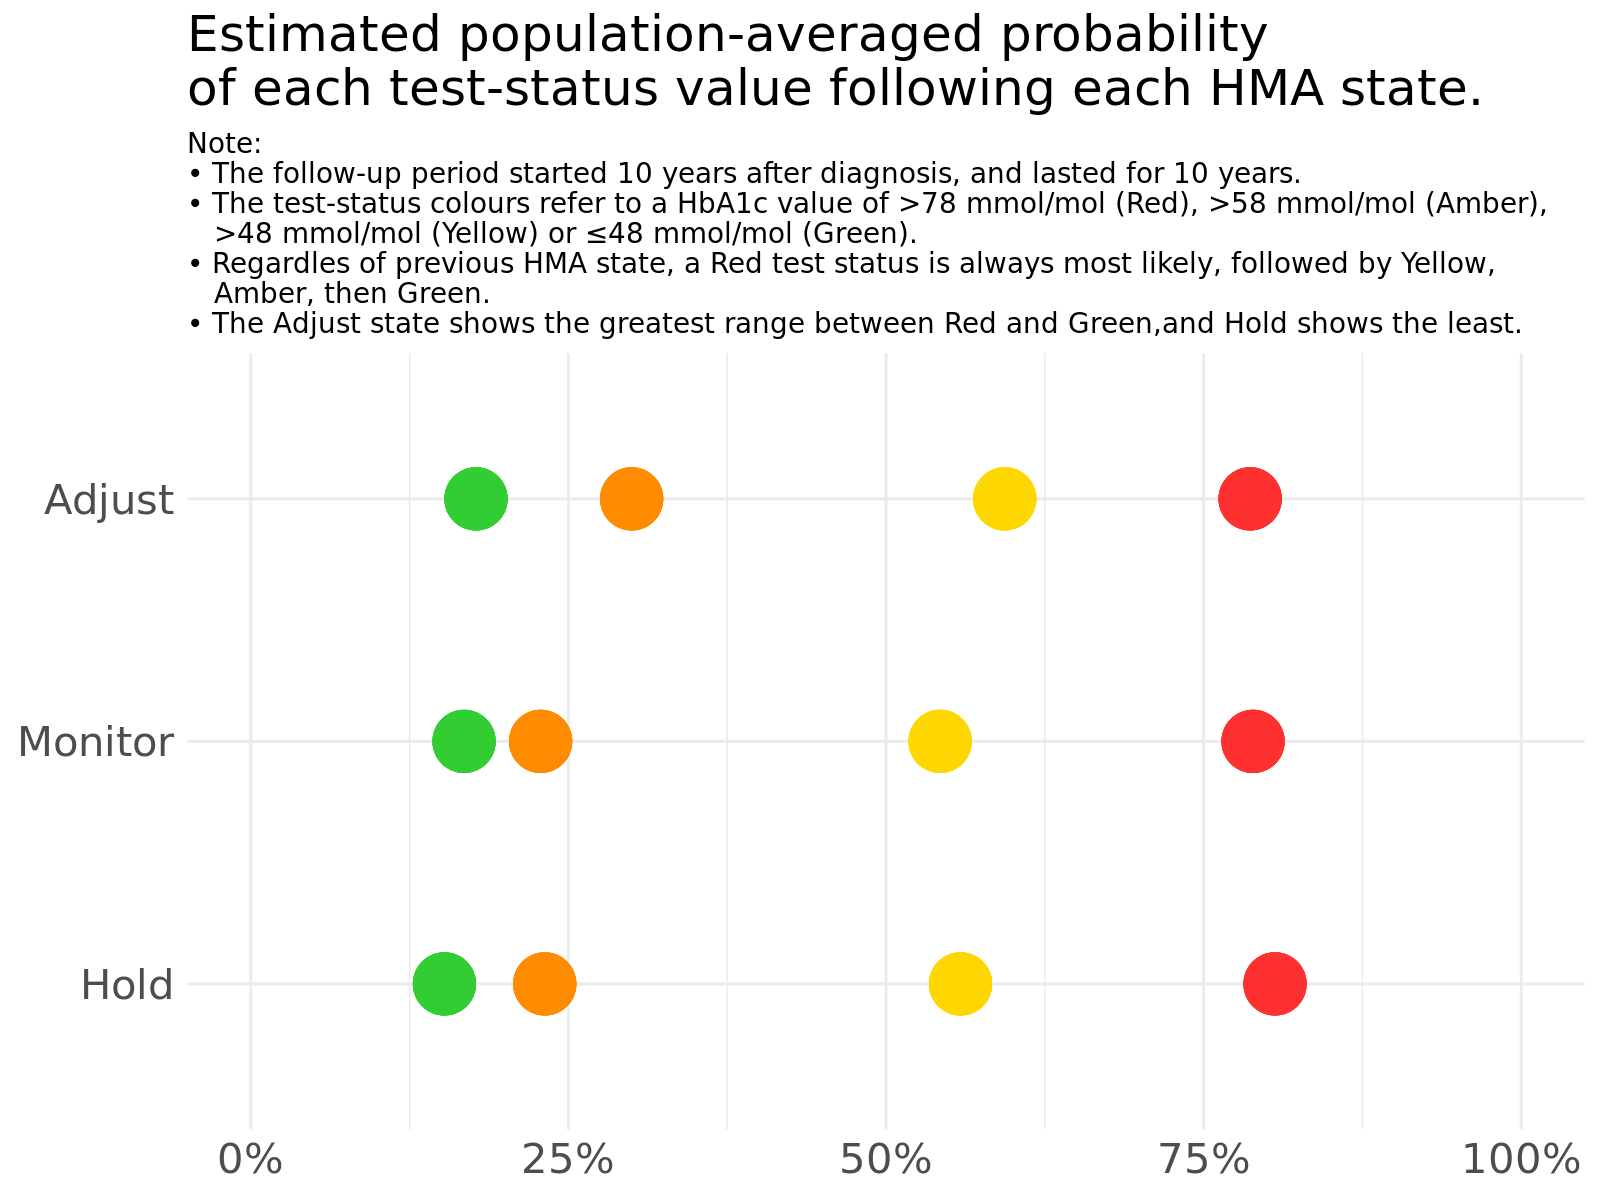

In [863]:
options( repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200 )

output1 <-
preds %>%
ggplot( aes( x = HMA_state, colour = intercept ) ) +
geom_point( aes( y = grp_avg ), size = 10 ) +
scale_colour_manual(
    values =
        df_event_factor %>%
        dplyr::select( event_colours_order ) %>%
        droplevels() %>%
        dplyr::pull()
) +
labs(
    title = "Estimated population-averaged probability\nof each test-status value following each HMA state."
    ,subtitle = paste0(
        "Note: \n"
        ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis, and lasted for ", followup_duration_in_years," years.\n")
        ,"\u2022 The test-status colours refer to a HbA1c value of >78 mmol/mol (Red), >58 mmol/mol (Amber),\n   >48 mmol/mol (Yellow) or \u226448 mmol/mol (Green).\n"
        ,"\u2022 Regardles of previous HMA state, a Red test status is always most likely, followed by Yellow,\n   Amber, then Green.\n"
        ,"\u2022 The Adjust state shows the greatest range between Red and Green,and Hold shows the least."
        )
) +
scale_y_continuous( labels = scales::percent_format(), limits = c( 0, 1 ) ) +
coord_flip() +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,axis.title = element_blank()
    ,plot.subtitle = element_text( size = 10 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,legend.title = element_blank()
    ,legend.position = 'none'
    ,axis.text = element_text( size = 15 )
)

output1

In [864]:
Sys.time() - script_start_time

Time difference of 1.028899 mins

## Conditioning on two preceding HMA states.
CB and I discussed whether it might be insightful to stratify the estimates based on the sequences of the two preceding HMA states rather than just the immediately-preceding HMA state.

To run these GEEs, I add a column to the dataset for the twice-preceding HMA state, and rerun the GEEs with the added covariate. The consequence of using a sequence of the two previous HMA states is that we exclude more patient records for which there were not two previous HMA states.

Firstly, I run the estimations.

In [865]:
# Make the new column for the dataset.
gee_dataset_2 <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::distinct( person_id, event_value, HMA) %>%
    dplyr::filter( stringr::str_detect( event_value, pattern = "Test" ) ) %>%
    dplyr::mutate( event_value = event_value %>% droplevels() %>% ordered() ) %>%
    dplyr::mutate( HMA = HMA %>% droplevels() ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, rn ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::rename(
        test_status = event_value
        ,previous_HMA_state = HMA
    ) %>%
    dplyr::mutate(
        previous_test_status = lag( test_status )
        ,previous_previous_HMA_state = lag( previous_HMA_state )
    ) %>%
    dplyr::ungroup() 


# Run the estimations.
GEE2_holdAsReferenceLevel <-
multgee::ordLORgee(
        formula = test_status ~ previous_HMA_state + previous_previous_HMA_state + previous_test_status
        ,link = "acl"
        ,id = person_id
        ,repeated = rn
        ,data = gee_dataset_2 %>% 
                    dplyr::mutate(
                        previous_HMA_state = relevel( as.factor( previous_HMA_state ), ref = 1 )
                        ,previous_previous_HMA_state = relevel( as.factor( previous_previous_HMA_state ), ref = 1 )
                    )
        ,LORstr = "time.exch"
    )


GEE2_monitorAsReferenceLevel <-
multgee::ordLORgee(
        formula = test_status ~ previous_HMA_state + previous_previous_HMA_state + previous_test_status
        ,link = "acl"
        ,id = person_id
        ,repeated = rn
        ,data = gee_dataset_2 %>% 
                    dplyr::mutate(
                        previous_HMA_state = relevel( as.factor( previous_HMA_state ), ref = 2 )
                        ,previous_previous_HMA_state = relevel( as.factor( previous_previous_HMA_state ), ref = 2 )
                    )
        ,LORstr = "time.exch"
    )

Again, I assess the generalisability of the estimates. I am still only concerned with the overall p-value and the p-values for the exposure dummy variables.

In [866]:
# Assess the generalisability of the estmimates.
print("GEE2_holdAsReferenceLevel")
pval_extraction <- summary( GEE2_holdAsReferenceLevel ) %>% `[`( c("pvalue", "coefficients"))
pval_model <- pval_extraction$pvalue %>% as.numeric()
pval_coeffs <- pval_extraction$coefficients[ c('previous_HMA_stateMonitor', 'previous_HMA_stateAdjust'), 'Pr(>|san.z|)']
pvals <- c(pval_model, pval_coeffs)
ifelse( pvals < 0.0001, "< 0.0001", pvals)

print("GEE2_monitorAsReferenceLevel")
pval_extraction <- summary( GEE2_monitorAsReferenceLevel ) %>% `[`( c("pvalue", "coefficients"))
pval_model <- pval_extraction$pvalue %>% as.numeric()
pval_coeffs <- pval_extraction$coefficients[ c('previous_HMA_stateHold', 'previous_HMA_stateAdjust' ), 'Pr(>|san.z|)']
pvals <- c(pval_model, pval_coeffs)
ifelse( pvals < 0.0001, "< 0.0001", pvals)

[1] "GEE2_holdAsReferenceLevel"


previous_HMA_stateMonitor  previous_HMA_stateAdjust 
               "< 0.0001"                "< 0.0001"                "< 0.0001"

[1] "GEE2_monitorAsReferenceLevel"


previous_HMA_stateHold previous_HMA_stateAdjust 
              "< 0.0001"               "< 0.0001"               "< 0.0001"

All p-values are lower than the default level of signficance (alpha = 0.05). Specifically, the GEEs output suggests that:
- there is less than a 1 in 10,000 chance that either GEE's coefficients are all compatible with them truly being zero.
- there is less than a 1 in 10,000 chance that any of the coefficients of interest are compatible with it truly being zero.

Since these probabilities are so low, I consider it reasonable to assume the coefficients are not truly zero. And if they are not truly zero, then the estimates from our sample are our best population estimates, for now.

Format the plot data.

In [867]:
# Make grid of possible inputs.
newdata_holdAsReferenceLevel_2 <- 
    expand.grid(
        previous_HMA_stateMonitor = c(0,1)
        ,previous_HMA_stateAdjust = c(0,1)
        ,previous_previous_HMA_stateMonitor = c(0,1)
        ,previous_previous_HMA_stateAdjust = c(0,1)
        ,previous_test_status = c(1:4)
    ) %>%
    dplyr::left_join(
        dplyr::bind_cols(
            previous_test_status = c(1:4)
            ,contr.poly(4)
        ) %>% `colnames<-`( c( 'previous_test_status', 'previous_test_status.L'
                              , 'previous_test_status.Q', 'previous_test_status.C' ) )
        ,by = join_by( previous_test_status )
    ) %>%
    dplyr::select( -previous_test_status ) %>%
    dplyr::filter( ( previous_HMA_stateMonitor + previous_HMA_stateAdjust) != 2 ) %>%
    dplyr::filter( ( previous_previous_HMA_stateMonitor + previous_previous_HMA_stateAdjust) != 2 ) %>%
    dplyr::arrange( previous_HMA_stateMonitor,	previous_HMA_stateAdjust, previous_previous_HMA_stateMonitor, previous_previous_HMA_stateAdjust )
intercepts_holdAsReferenceLevel_2 <-
    GEE2_holdAsReferenceLevel %>%
    coef() %>%
    `[`( 1:3 ) 
covars_holdAsReferenceLevel_2 <-
    GEE2_holdAsReferenceLevel %>%
    coef() %>%
    `[`( 4:length( . ) ) %>%
    `*`( newdata_holdAsReferenceLevel_2 ) %>%
    rowSums()
# Red: use the reciprocal of the RedToAmber intercept, plus the covariate because reciprocating makes Red = 1 and Amber = 0.
preds_Red <- exp( -intercepts_holdAsReferenceLevel_2[1] + covars_holdAsReferenceLevel_2 ) / ( 1 + exp( -intercepts_holdAsReferenceLevel_2[1] + covars_holdAsReferenceLevel_2 ) )
# Amber: use RedToAmber intercept, plus covariates because Red = 0 and Amber = 1.
preds_Amber <- exp( intercepts_holdAsReferenceLevel_2[1] + covars_holdAsReferenceLevel_2 ) / ( 1 + exp( intercepts_holdAsReferenceLevel_2[1] + covars_holdAsReferenceLevel_2 ) )
# Yellow: use AmberToYellow intercept, plus covariates because Amber = 0 and Yellow = 1.
preds_Yellow <- exp( intercepts_holdAsReferenceLevel_2[2] + covars_holdAsReferenceLevel_2 ) / ( 1 + exp( intercepts_holdAsReferenceLevel_2[2] + covars_holdAsReferenceLevel_2 ) )
# Green: use YellowToGreen intercept, plus covariates because Yellow = 0 and Green = 1.
preds_Green <- 1 - ( exp( intercepts_holdAsReferenceLevel_2[3] + covars_holdAsReferenceLevel_2 ) / ( 1 + exp( intercepts_holdAsReferenceLevel_2[3] + covars_holdAsReferenceLevel_2 ) ) )
preds_2 <- dplyr::bind_cols(
    preds_Red = preds_Red
    ,preds_Amber = preds_Amber
    ,preds_Yellow = preds_Yellow
    ,preds_Green = preds_Green
    ,HMA_state = newdata_holdAsReferenceLevel_2 %>%
                    dplyr::transmute(
                        HMA_state = dplyr::case_when(
                            previous_HMA_stateMonitor == 0 & previous_HMA_stateAdjust == 0 ~ 'Hold'
                            ,previous_HMA_stateMonitor == 1 & previous_HMA_stateAdjust == 0 ~ 'Monitor'
                            ,previous_HMA_stateMonitor == 0 & previous_HMA_stateAdjust == 1 ~ 'Adjust'

                            ,TRUE ~ NA
                        )
                    )
    ,HMA_state_2 = newdata_holdAsReferenceLevel_2 %>%
                    dplyr::transmute(
                        HMA_state_2 = dplyr::case_when(
                            previous_previous_HMA_stateMonitor == 0 & previous_previous_HMA_stateAdjust == 0 ~ 'Hold'
                            ,previous_previous_HMA_stateMonitor == 1 & previous_previous_HMA_stateAdjust == 0 ~ 'Monitor'
                            ,previous_previous_HMA_stateMonitor == 0 & previous_previous_HMA_stateAdjust == 1 ~ 'Adjust'

                            ,TRUE ~ NA
                        )
                    )
    ,previous_test_status = rep( c( 'Red', 'Amber', 'Yellow', 'Green' ), times = 9 )
) %>%
pivot_longer(
    cols = contains( "preds" )
    ,names_to = "intercept"
    ,values_to = "Estimation"
) %>%
dplyr::group_by( HMA_state, HMA_state_2, intercept ) %>%
dplyr::mutate(
    grp_avg = mean( Estimation )
) %>%
dplyr::ungroup() %>%
# Make `intercept` into a factor and order it.
dplyr::mutate(
    intercept = factor( intercept,  levels = c( 'preds_Red', 'preds_Amber', 'preds_Yellow', 'preds_Green' ) )
) %>%
dplyr::mutate(
    HMA_state = factor( HMA_state,  levels = c( 'Hold', 'Monitor', 'Adjust' ) )
    ,HMA_state_2 = factor( HMA_state_2,  levels = c( 'Hold', 'Monitor', 'Adjust' ) )
) %>%
dplyr::arrange( intercept, HMA_state, HMA_state_2 )

Make the plot.

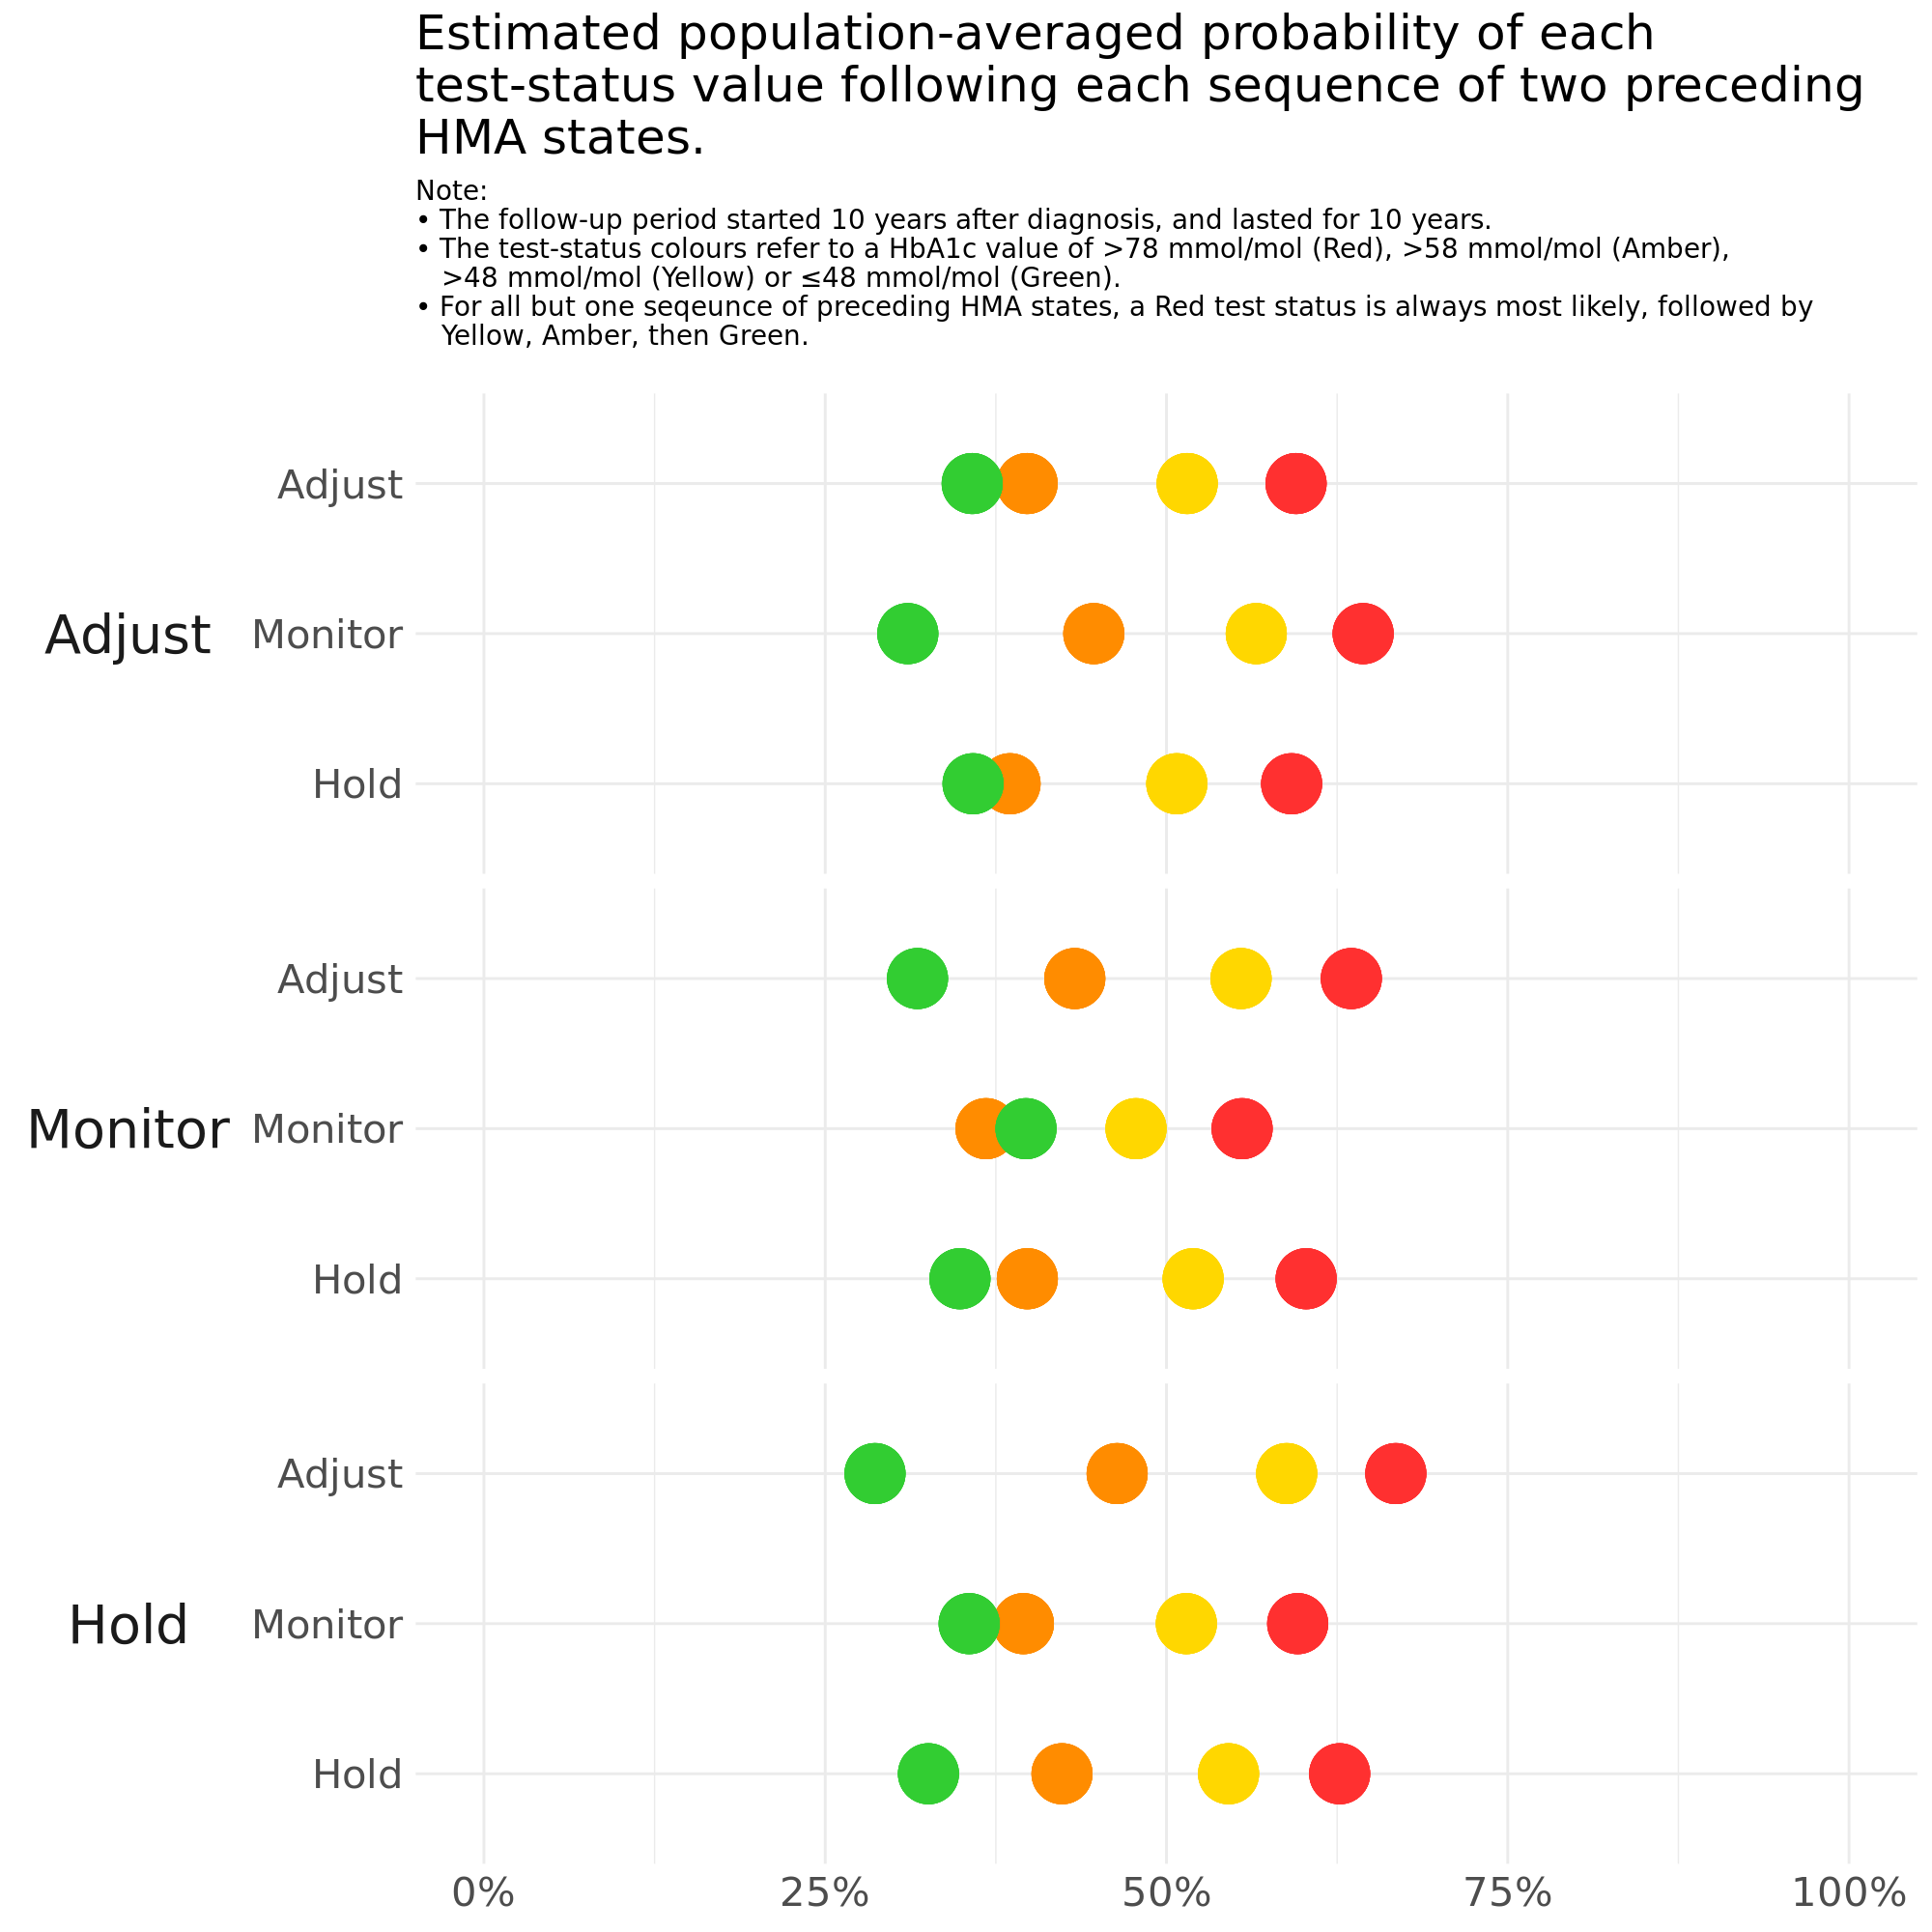

In [868]:
options( repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200 )

output2 <-
preds_2 %>%
ggplot( aes( x = HMA_state, colour = intercept ) ) +
geom_point( aes( y = grp_avg ), size = 10 ) +
scale_colour_manual(
    values =
        df_event_factor %>%
        dplyr::select( event_colours_order ) %>%
        droplevels() %>%
        dplyr::pull()
) +
labs(
    title = "Estimated population-averaged probability of each\ntest-status value following each sequence of two preceding\nHMA states."
    ,subtitle = paste0(
        "Note: \n"
        ,paste0("\u2022 The follow-up period started ", followup_delay_in_years," years after diagnosis, and lasted for ", followup_duration_in_years," years.\n")
        ,"\u2022 The test-status colours refer to a HbA1c value of >78 mmol/mol (Red), >58 mmol/mol (Amber),\n   >48 mmol/mol (Yellow) or \u226448 mmol/mol (Green).\n"
        ,"\u2022 For all but one seqeunce of preceding HMA states, a Red test status is always most likely, followed by\n   Yellow, Amber, then Green.\n"
        )
) +
scale_y_continuous( labels = scales::percent_format(), limits = c( 0, 1 ) ) +
facet_grid( rows = vars( fct_rev( HMA_state_2 ) ), switch = "both", scales = "free_x", space = "free_x") +
coord_flip() +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,strip.placement = "outside"
    ,strip.text.y.left = element_text( size = 20, angle = 0 )
    ,axis.title = element_blank()
    ,plot.subtitle = element_text( size = 10 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,legend.title = element_blank()
    ,legend.position = 'none'
    ,axis.text = element_text( size = 15 )
)

output2

In [869]:
Sys.time() - script_start_time

Time difference of 1.441368 mins

## Outputs.
The expected outputs from this notebook were:
1. Three, four-colour plots showing the average estimated population-averaged probability of each test-status value following each HMA state.
2. Three, four-colour plots showing the average estimated population-averaged probability of each test-status value following each sequence of two preceding HMA states.
3. The exp(coefficient) of the M-state dummy covariate in the GEE with 'Hold' as the reference tells us the population-averaged multiplicative difference in the odds of having an adjacent test-status value, when comparing records that indicated 'Monitor' rather that 'Hold'.
4. The exp(coefficient) of the A-state dummy covariate in the GEE with 'Hold' as the reference tells us the population-averaged multiplicative difference in the odds of having an adjacent test-status value, when comparing records that indicated 'Adjust' rather than 'Hold'.
5. The exp(coefficient) of the A-state dummy covariate in the GEE with 'Monitor' as the reference tells us the population-averaged multiplicative difference in the odds of having an adjacent test-status value, when comparing records that indicated 'Adjust' rather than 'Monitor'.

Output 1 and Output 2 are the two plots that have been presented, and are stored in variables `output1` and `output2`. Outputs 3-5 are summarised below.

In [870]:
output3 <- GEE_holdAsReferenceLevel %>% coef() %>% `*`( -1) %>% `[[`('previous_HMA_stateMonitor') %>% exp()
output4 <- GEE_holdAsReferenceLevel %>% coef() %>% `*`( -1) %>% `[[`('previous_HMA_stateAdjust') %>% exp()
output5 <- GEE_monitorAsReferenceLevel %>% coef() %>% `*`( -1) %>% `[[`('previous_HMA_stateAdjust') %>% exp()

data.frame(
    Output = c( 'Output 3', 'Output 4', 'Output 5')
    ,Odds_ratio = c( output3, output4, output5 ) %>% round( 2 )
    ,Odds_interpretation = c(
        paste0(
            "On average, records indicating a 'Monitor' HMA state had "
            ,output3 %>% round( 2 )
            ,"-times the odds of a better subsequent test-status value compared to records indicating a 'Hold' "
            ,"HMA state, when all observed covariates are held constant and all unobsevred covariates are free to vary."
        )
        ,paste0(
            "On average, records indicating a 'Adjust' HMA state had "
            ,output4 %>% round( 2 )
            ,"-times the odds of a better subsequent test-status value compared to records indicating a 'Hold' "
            ,"HMA state, when all observed covariates are held constant and all unobsevred covariates are free to vary."
        )
        ,paste0(
            "On average, records indicating a 'Adjust' HMA state had "
            ,output5 %>% round( 2 )
            ,"-times the odds of a better subsequent test-status value compared to records indicating a 'Monitor' "
            ,"HMA state, when all observed covariates are held constant and all unobsevred covariates are free to vary."
        )
    )
    ,Odds_plainEnglish = c(
        "'Hold' is associated with better test-status values and 'Monitor' is associated with worse."
        ,"'Hold' is associated with better test-status values and 'Adjust' is associated with worse."
        ,"'Monitor' is associated with better test-status values and 'Adjust' is associated with worse."
    )
    ,Probability = ( c( output3, output4, output5 ) / (1 + c( output3, output4, output5 ) ) ) %>% round( 2 )
    ,Probs_interpretation = c(
        paste0(
            "The average population-averaged probability of having a better test-status value if your "
            ,"previous HMA state was 'Monitor', in a comparison between records with a previous HMA state "
            ,"of either 'Hold' or 'Monitor', and when all observed covariates are held constant and "
            ,"all unobsevred covariates are free to vary."
        )
        ,paste0(
            "The average population-averaged probability of having a better test-status value if your "
            ,"previous HMA state was 'Adjust', in a comparison between records with a previous HMA state "
            ,"of either 'Hold' or 'Adjust', and when all observed covariates are held constant and "
            ,"all unobsevred covariates are free to vary."
        )
        ,paste0(
            "The average population-averaged probability of having a better test-status value if your "
            ,"previous HMA state was 'Adjust', in a comparison between records with a previous HMA state "
            ,"of either 'Monitor' or 'Adjust', and when all observed covariates are held constant and "
            ,"all unobsevred covariates are free to vary."
        )
    )
)

Output,Odds_ratio,Odds_interpretation,Odds_plainEnglish,Probability,Probs_interpretation
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
Output 3,0.78,"On average, records indicating a 'Monitor' HMA state had 0.78-times the odds of a better subsequent test-status value compared to records indicating a 'Hold' HMA state, when all observed covariates are held constant and all unobsevred covariates are free to vary.",'Hold' is associated with better test-status values and 'Monitor' is associated with worse.,0.44,"The average population-averaged probability of having a better test-status value if your previous HMA state was 'Monitor', in a comparison between records with a previous HMA state of either 'Hold' or 'Monitor', and when all observed covariates are held constant and all unobsevred covariates are free to vary."
Output 4,0.41,"On average, records indicating a 'Adjust' HMA state had 0.41-times the odds of a better subsequent test-status value compared to records indicating a 'Hold' HMA state, when all observed covariates are held constant and all unobsevred covariates are free to vary.",'Hold' is associated with better test-status values and 'Adjust' is associated with worse.,0.29,"The average population-averaged probability of having a better test-status value if your previous HMA state was 'Adjust', in a comparison between records with a previous HMA state of either 'Hold' or 'Adjust', and when all observed covariates are held constant and all unobsevred covariates are free to vary."
Output 5,0.52,"On average, records indicating a 'Adjust' HMA state had 0.52-times the odds of a better subsequent test-status value compared to records indicating a 'Monitor' HMA state, when all observed covariates are held constant and all unobsevred covariates are free to vary.",'Monitor' is associated with better test-status values and 'Adjust' is associated with worse.,0.34,"The average population-averaged probability of having a better test-status value if your previous HMA state was 'Adjust', in a comparison between records with a previous HMA state of either 'Monitor' or 'Adjust', and when all observed covariates are held constant and all unobsevred covariates are free to vary."


The ranking of the odds ratios suggest that the extent to which the expected association between HMA state and test-status manifests is sensibly proportional. Specifically, the Adjust-Hold difference is worst, the Monitor-Hold difference is best, and the Adjust-Monitr difference is in between.

I'm massively struggling with the finding that the exponentiated coefficients suggest worse HMA states are associated with better test-status values. This goes against intuition, my Sankey plots, and my probability plots.

I've just found that I might be calculating my probabilities incorrectly (see page 949 of https://journals.sagepub.com/doi/pdf/10.1177/1536867X1401400414).

The same authors do a worked example of fitting am adjacent category ordinal regression model (page 682; https://journals.sagepub.com/doi/pdf/10.1177/1536867X1701700308#:~:text=These%20tests%20include%20an%20ordinal,the%20Lipsitz%20likelihood%2Dratio%20test).

I've just discovered that Touloumis defines his adjacent category logits reciprocally, i.e. category_i:category_i+1 instead of category_i+1:category_i (equation 2, page 3, doi: 10.18637/jss.v064.i08). This solves my interpretation of the GEE coefficients.

If their reciprocal-odds interpration is true, then my GEEs make sense. Then comes the question of the plotted probabilities: are the calculated correctly?